C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14716\1263914393.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)



Root Mean Squared Error (RMSE): 3261.79


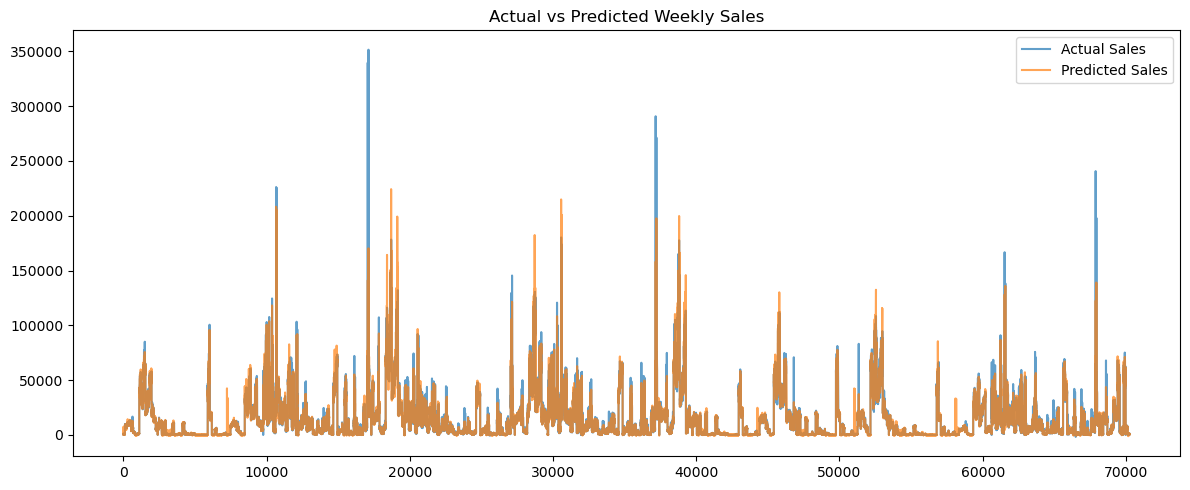

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Load datasets (Update path if necessary)
train = pd.read_csv(r'C:\Users\LENOVO\Documents\train.csv')
stores = pd.read_csv(r'C:\Users\LENOVO\Documents\stores.csv')
features = pd.read_csv(r'C:\Users\LENOVO\Documents\features.csv')


# Merge datasets
df = train.merge(stores, on='Store').merge(features, on=['Store', 'Date', 'IsHoliday'])

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by Date for time-aware modeling
df.sort_values('Date', inplace=True)

# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day

# Create lag features (1 week, 2 weeks before)
df = df.sort_values(['Store', 'Dept', 'Date'])
df['Sales_lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Sales_lag_2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)

# Fill missing lag values
df.fillna(method='bfill', inplace=True)

# Drop unnecessary columns
df.drop(['Date'], axis=1, inplace=True)

# Label encode 'IsHoliday' and 'Type'
df['IsHoliday'] = df['IsHoliday'].astype(int)
df['Type'] = df['Type'].map({'A': 1, 'B': 2, 'C': 3})

# Define features and target
features = [col for col in df.columns if col not in ['Weekly_Sales']]
X = df[features]
y = df['Weekly_Sales']

# TimeSeries Split (simulate real-world forecasting)
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Train XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nRoot Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs predicted sales
plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual Sales', alpha=0.7)
plt.plot(y_pred, label='Predicted Sales', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()
